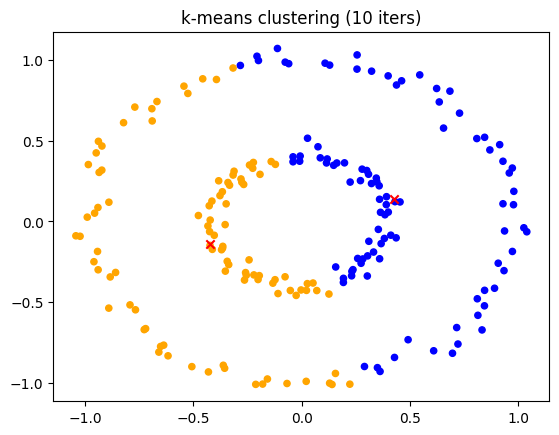

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

X, _ = datasets.make_circles(n_samples=200,
                             factor=0.4,
                             noise=0.04,
                             random_state=13)

mu = np.array([[0.0, 0.0],
               [1.0, 0.0]])

for t in range(10):
    dists = np.linalg.norm(X[:,None,:] - mu[None,:,:], axis=2)**2
    labels = dists.argmin(axis=1)
    for k in (0,1):
        if np.any(labels==k):
            mu[k] = X[labels==k].mean(axis=0)

colors = np.array(['orange','blue'])
plt.scatter(X[:,0], X[:,1], s=20, c=colors[labels])
plt.scatter(mu[:,0], mu[:,1], c='red', marker='x')
plt.title("k-means clustering (10 iters)")
plt.savefig("kmeans_final.png")
plt.show()

k-means is obviously not good with this data at all. it cuts the data in half rather than identifying the inner circle vs outer circle. this is because k-means only measures based on the distance to a point, and cannot deal with complex shapes. 

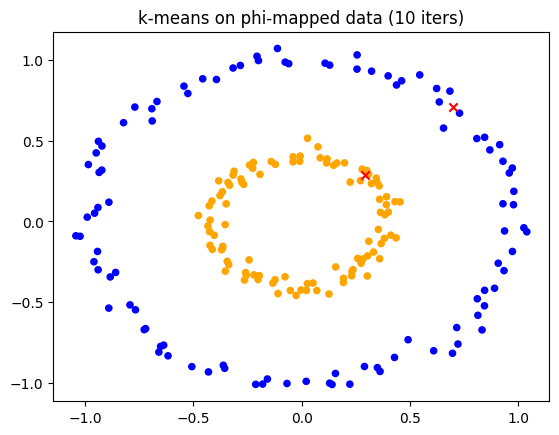

In [9]:
Phi = np.column_stack([
    X[:,0]**2,
    X[:,1]**2,
    np.sqrt(2)*X[:,0]*X[:,1]
])

mu3 = np.array([[0.0,0.0,0.0],
                [1.0,1.0,0.0]])

for t in range(10):
    dists3 = np.linalg.norm(Phi[:,None,:] - mu3[None,:,:], axis=2)**2
    labels3 = dists3.argmin(axis=1)
    for k in (0,1):
        if np.any(labels3==k):
            mu3[k] = Phi[labels3==k].mean(axis=0)

plt.scatter(X[:,0], X[:,1], s=20, c=colors[labels3])
plt.scatter(
    np.sqrt(mu3[:,0]), np.sqrt(mu3[:,1]),
    c='red', marker='x'
)
plt.title("k-means on phi‑mapped data (10 iters)")
plt.savefig("kmeans_lifted.png")
plt.show()


in the lifted space, the two clusters become linearly seperable, so k-means is able to separate the inner and outer circle now. 

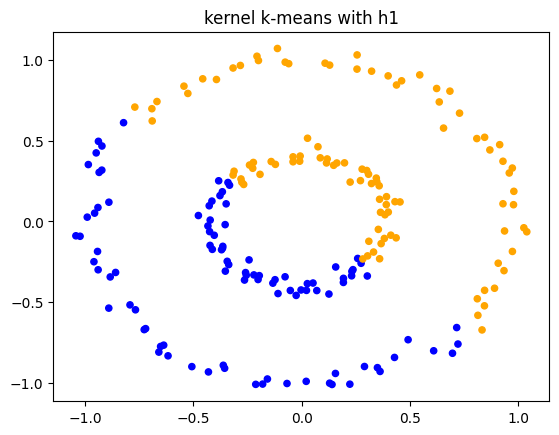

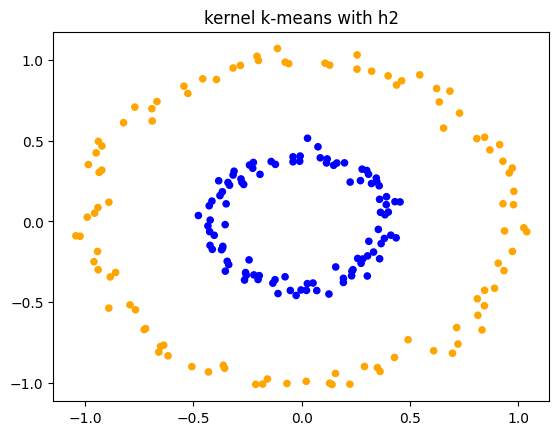

In [10]:
def kernel_matrix(X, h):
    n = len(X)
    H = np.empty((n,n))
    for i in range(n):
        for j in range(n):
            H[i,j] = h(X[i], X[j])
    return H

h1 = lambda x, y: 1 + np.dot(x,y)
h2 = lambda x, y: (1 + np.dot(x,y))**2

for name, h in [('h1', h1), ('h2', h2)]:
    H = kernel_matrix(X, h)
    # initialize clusters from provided .npy
    init = np.load('init_clusters.npy')
    labels = init.copy()
    for t in range(10):
        clusters = [np.where(labels==k)[0] for k in (0,1)]
        # assign step
        new_labels = labels.copy()
        for i in range(len(X)):
            best = None
            best_val = np.inf
            for k in (0,1):
                Ck = clusters[k]
                nk = len(Ck)
                if nk==0:
                    continue
                T1 = -2.0/nk * H[i, Ck].sum()
                T2 = 1.0/(nk**2) * H[np.ix_(Ck, Ck)].sum()
                val = T1 + T2
                if val < best_val:
                    best_val, best = val, k
            new_labels[i] = best
        labels = new_labels

    # plot
    plt.figure()
    plt.scatter(X[:,0], X[:,1], s=20, c=colors[labels.astype(int)])
    plt.title(f"kernel k‐means with {name}")
    plt.savefig(f"kkm_{name}.png")
    plt.show()


h1 gets a global shift of the linear kernel, which isnt enough to split the circles.

h2 is a polynomial kernel of degree 2, which matches the phi in (d), so separates the inner vs outer ring. 

initialisation is very important. with a poorly matched distance in iether method, random starts give variable and poor results. using the right kernel (degree 2 polynomial) the data becomes linearly seperable in feature space and initialisation sensitivity then disappears, with the cost of O(n^2) computation. 

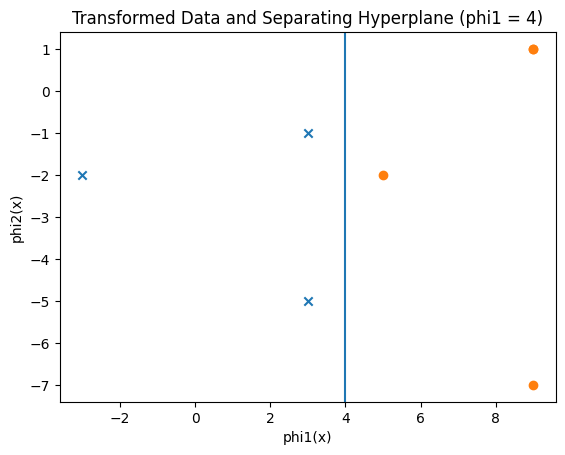

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X = np.array([[1,0], [0,1], [0,-1], [-1,0], [0,2], [0,-2], [-2,0]])
y = np.array([-1, -1, -1, 1, 1, 1, 1])

phi1 = 2*X[:,1]**2 - 4*X[:,0] + 1
phi2 = X[:,0]**2 - 2*X[:,1] - 3

plt.figure()
neg = (y == -1)
pos = (y == 1)
plt.scatter(phi1[neg], phi2[neg], marker='x')
plt.scatter(phi1[pos], phi2[pos], marker='o')
plt.axvline(4)
plt.xlabel('phi1(x)')
plt.ylabel('phi2(x)')
plt.title('Transformed Data and Separating Hyperplane (phi1 = 4)')
plt.show()


you can approximate a hard margin svm by simply setting C to a very large value. this effectively forces the optimiser to drive all other variables to essentially zero. 

In [ ]:
from sklearn.svm import SVC
import numpy as np

Xphi = np.column_stack((phi1, phi2))
y = np.array([-1, -1, -1, +1, +1, +1, +1])

clf = SVC(kernel='linear', C=1e6)
clf.fit(Xphi, y)

alpha = np.zeros(len(y))
alpha[clf.support_] = np.abs(clf.dual_coef_[0])
print("alpha (rounded):", np.round(alpha, 3))
print("support vector indices (1‑based):", clf.support_ + 1)
print("training error:", np.mean(clf.predict(Xphi) != y))

alpha (rounded): [0.    0.125 0.375 0.5   0.    0.    0.   ]
Support vector indices (1‑based): [2 3 4]
Training error: 0.0


In [ ]:
clf_k = SVC(kernel='poly', degree=2, gamma=1, coef0=2, C=1e6)
clf_k.fit(X, y)
alpha_k = np.zeros(len(y))
alpha_k[clf_k.support_] = np.abs(clf_k.dual_coef_[0])
print("alpha (rounded):", np.round(alpha_k, 3))
print("support vectors (1‑based):", clf_k.support_ + 1)
print("training error:", np.mean(clf_k.predict(X) != y))

α (rounded): [0.    0.459 0.474 0.533 0.196 0.204 0.   ]
Support vectors (1‑based): [2 3 4 5 6]
Training error: 0.0


in the first part, we used a 2 dimensional feature map to make it linearly separable by a line. in the second part, we ran a hard margin svm on the same phi1 phi2 points. since they were already seperable with a margin, the svm finds the same seperator. in the third part, we ran the hard margin svm on the original data but with a degree 2 polynomial kernel. only phi1 and phi2 are actually needed to seperate the data, so the optimiser gives zero weight to the other dimensions and we end up with the same hyperplane and same support vectors. the only differences is where in i and ii we compute phi1 and phi2 but in iii it does that implicitly. i and ii are both in 2d, but iii works in 6d implicitly. since the data was already seperable in 2d space, iii and ii both get the same answer. so iii and ii aren't better than either. though iii will use more computational cost if more data is used. 